In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import math
import methods
import itertools

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

In [3]:
kwargs

{'num_workers': 1, 'pin_memory': True}

In [4]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomHorizontalFlip(p=0.5)] )

cifar_full_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test_set = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

Files already downloaded and verified


In [6]:
test_imgs = []
test_labels = []
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(12):
    test_imgs.append(cifar_full_train_set[i][0].permute(1,2,0)/2+0.5)
    test_labels.append(classes[cifar_full_train_set[i][1]])

In [7]:
# methods.draw_img_gallery(test_imgs, labels = test_labels, rows = 3)
train_set_length = len(cifar_full_train_set)
train_size, validate_size = int(0.9 * train_set_length),int(0.1 * train_set_length)
cifar_train_set, cifar_validate_set = torch.utils.data.random_split(cifar_full_train_set, [train_size, validate_size])

In [8]:
train_loader = torch.utils.data.DataLoader(
    cifar_train_set,
    batch_size=8,
    shuffle=True,
    **kwargs
)

validate_loader = torch.utils.data.DataLoader(
    cifar_validate_set,
    batch_size=8,
    shuffle=False,
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    cifar_test_set,
    batch_size=8,
    shuffle=False,
    **kwargs
)

In [9]:
aaa = None
for (k, i) in train_loader:
    print(k, i)
    aaa = k
    break

tensor([[[[-0.2471, -0.3882, -0.3647,  ...,  0.4667,  0.3882,  0.3020],
          [ 0.1922,  0.0588, -0.3725,  ...,  0.3412,  0.3725,  0.3647],
          [-0.0745,  0.1294,  0.0745,  ...,  0.4745,  0.4431,  0.3725],
          ...,
          [ 0.0588,  0.0039,  0.2706,  ...,  0.3020,  0.1373, -0.2078],
          [ 0.2627,  0.2392,  0.2549,  ...,  0.3569,  0.0588, -0.1294],
          [ 0.0510,  0.0667, -0.0588,  ...,  0.2471,  0.0039, -0.0510]],

         [[ 0.0039, -0.2000, -0.2863,  ...,  0.5529,  0.6078,  0.8039],
          [ 0.4588,  0.2863, -0.2000,  ...,  0.4667,  0.6235,  0.8824],
          [ 0.1843,  0.3412,  0.3020,  ...,  0.6706,  0.7333,  0.8980],
          ...,
          [ 0.1686,  0.0902,  0.4902,  ...,  0.7333,  0.6314,  0.4039],
          [ 0.3725,  0.3333,  0.5059,  ...,  0.8196,  0.5529,  0.4275],
          [ 0.1529,  0.1451,  0.1843,  ...,  0.7333,  0.5216,  0.4667]],

         [[-0.5686, -0.5686, -0.5137,  ...,  0.1059,  0.0588, -0.0824],
          [-0.0118, -0.0745, -

In [10]:
class TestNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2_1 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3_1 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.bn1(self.pool1(F.relu(x)))

        res2 = x
        x = self.conv2_2(self.conv2_1(x))
        x += res2
        x = self.bn2(self.pool2(F.relu(x)))

        res3 = x
        x = self.conv3_2(self.conv3_1(x))
        x += res3
        x = self.bn3(self.pool3(F.relu(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
net = TestNN()
if device=='cuda':
    net = net.cuda()

In [12]:
def get_accuracy(net, loader):
    net.eval()
    with torch.no_grad():
        correct_count = 0
        total_count = 0
        for (data, labels) in loader:
            data = data.to(device)
            labels = labels.to(device)

            pred = net(data)
            pred_labels = torch.argmax(pred, 1)
            
            correct_count += (pred_labels == labels).sum().item()
            total_count += len(labels)

    return correct_count / total_count

In [13]:
get_accuracy(net, validate_loader)

I:\Anaconda3\envs\hhx\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.1102

In [14]:
epoch_num = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

In [15]:
loss_list = []
acc_list = []
epoch_list = []

net.train()

for epoch in range(epoch_num):

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1875 == 1874:
            # print every 625 mini-batches

            acc = get_accuracy(net, validate_loader)

            epoch_list.append(epoch)
            loss_list.append(running_loss / 1875)
            acc_list.append(acc)
            print('[%d, %5d] acc: %.4f loss: %.4f' %
                  (epoch + 1, i + 1, acc, running_loss / 1875))
            running_loss = 0.0

torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Si

KeyboardInterrupt: 

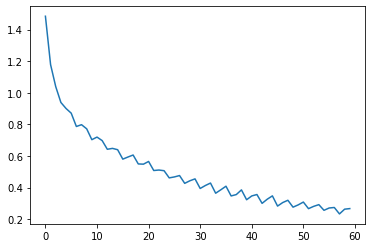

In [117]:
plt.plot(loss_list)
plt.show()

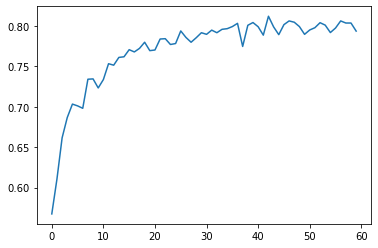

In [118]:
plt.plot(acc_list)
plt.show()

In [119]:
get_accuracy(net, test_loader)

0.91068

In [120]:
def get_confusion(net, loader, classes):
    
    mat = torch.zeros(len(classes), len(classes))
    net.eval()

    with torch.no_grad():
        correct_count = 0
        total_count = 0

        for (data, labels) in loader:
            data = data.to(device)
            labels = labels.to(device)

            pred = net(data)
            pred_labels = torch.argmax(pred, 1)

            stack = torch.stack( (labels, pred_labels), dim = 1)
            for l in stack:
                correct_l, pred_l = l.tolist()
                mat[correct_l, pred_l] += 1

    return mat

In [121]:
confusion = get_confusion(net, test_loader, classes)

In [138]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
	# 。。。。。。。。。。。。新增代码开始处。。。。。。。。。。。。。。。。
	# x,y轴长度一致(问题1解决办法）
    plt.axis("equal")
    # x轴处理一下，如果x轴或者y轴两边有空白的话(问题2解决办法）
    ax = plt.gca()  # 获得当前axis
    left, right = plt.xlim()  # 获得x轴最大最小值
    ax.spines['left'].set_position(('data', left))
    ax.spines['right'].set_position(('data', right))
    for edge_i in ['top', 'bottom', 'right', 'left']:
        ax.spines[edge_i].set_edgecolor("white")
	# 。。。。。。。。。。。。新增代码结束处。。。。。。。。。。。。。。。。

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j]) if normalize else int(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if num > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

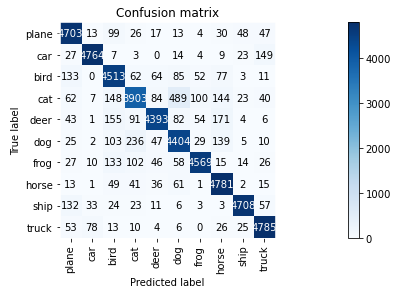

In [139]:
plot_confusion_matrix(confusion, classes)